In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [59]:
matches = pd.read_csv('./dataset/t20i_Matches_Data.csv')
batting = pd.read_csv('./dataset/t20i_Batting_Card.csv')
bowling = pd.read_csv('./dataset/t20i_Bowling_Card.csv')
players = pd.read_csv('./dataset/players_info.csv')

print(f"Matches: {len(matches)}")
print(f"Batting records: {len(batting)}")
print(f"Bowling records: {len(bowling)}")
print(f"Players: {len(players)}")

Matches: 2592
Batting records: 56357
Bowling records: 30648
Players: 6701


In [60]:
matches.head()

,T20I Match No,Match ID,Match Name,Series ID,Series Name,Match Date,Match Format,Team1 ID,Team1 Name,Team1 Captain,...,Umpire 2,Match Referee,Toss Winner,Toss Winner Choice,Match Winner,Match Result Text,MOM Player,Team1 Playing 11,Team2 Playing 11,Debut Players
0,52,291356,Australia Vs India Only T20I,291355,India tour of Australia - 2007 (2007/08),2008-02-01,T20,6,India,7593,...,SJA Taufel,JJ Crowe,India,bat,Australia,Australia won by 9 wickets (with 52 balls rema...,8876.0,"['7773', '7781', '8813', '8742', '48405', '759...","['4176', '8876', '6253', '6256', '4382', '1198...","['11984', '49327', '48319']"
1,54,300436,New Zealand Vs England 2Nd T20I,300418,England tour of New Zealand - 2008 (2007/08),2008-02-07,T20,1,England,2314,...,GAV Baxter,AG Hurst,England,bat,England,England won by 50 runs,2314.0,"['11556', '44660', '8107', '7822', '2314', '63...","['44946', '10384', '44930', '10381', '9570', '...","['47488', '10325']"
2,65,361531,Netherlands Vs Scotland 2Nd Semi Final,353665,"ICC World Twenty20 Qualifier Bermuda, Canada, ...",2008-08-04,T20,30,Scotland,45548,...,PK Baldwin,BC Broad,Netherlands,bowl,Netherlands,Netherlands won by 5 wickets (with 12 balls re...,45358.0,"['45548', '46048', '46142', '8221', '4334', '4...","['10323', '48655', '6362', '49443', '45358', '...",[]
3,66,354459,Kenya Vs Scotland 3Rd Place Playoff,353665,"ICC World Twenty20 Qualifier Bermuda, Canada, ...",2008-08-04,T20,26,Kenya,2265,...,PK Baldwin,BC Broad,Kenya,bat,Scotland,Scotland won by 9 wickets (with 11 balls remai...,45548.0,"['10364', '2264', '49383', '2265', '2268', '50...","['45548', '46048', '46142', '8221', '4334', '4...","['50293', '50293']"
4,69,361653,Sri Lanka Vs Zimbabwe 1St Match,361644,T20 Canada in Canada - 2008 (2008/09),2008-10-10,T20,9,Zimbabwe,45326,...,MR Benson,JJ Crowe,Sri Lanka,bowl,Sri Lanka,Sri Lanka won by 5 wickets (with 6 balls remai...,50377.0,"['10639', '10423', '47619', '10421', '21364', ...","['48468', '7419', '15273', '8195', '6315', '48...","['50377', '47210', '12209', '15273', '48468', ..."


In [61]:
batting_agg = batting.groupby('Match ID').agg({
    'runs': 'sum',
    'balls': 'sum',
    'fours': 'sum',
    'sixes': 'sum',
    'strikeRate': 'mean'
}).reset_index()

batting_agg.columns = ['Match ID', 'total_runs', 'total_balls', 'total_fours', 'total_sixes', 'avg_sr']

In [62]:
bowling_agg = bowling.groupby('Match ID').agg({
    'wickets': 'sum',
    'economy': 'mean',
    'dots': 'sum'
}).reset_index()

bowling_agg.columns = ['Match ID', 'total_wickets', 'avg_economy', 'total_dots']

In [63]:
df = matches.copy()
df = df.merge(batting_agg, on='Match ID', how='left')
df = df.merge(bowling_agg, on='Match ID', how='left')

In [64]:
df = df.dropna(subset=['Team1 Runs Scored', 'Team2 Runs Scored'])

df['toss_won'] = (df['Toss Winner'] == df['Team1 Name']).astype(int)
df['bat_first'] = (df['Toss Winner Choice'] == 'bat').astype(int)
df['venue'] = df['Match Venue (City)'].fillna('Unknown')
df['country'] = df['Match Venue (Country)'].fillna('Unknown')

df['total_fours'] = df['total_fours'].fillna(0)
df['total_sixes'] = df['total_sixes'].fillna(0)
df['avg_sr'] = df['avg_sr'].fillna(100)
df['total_wickets'] = df['total_wickets'].fillna(0)
df['avg_economy'] = df['avg_economy'].fillna(8)

print(f"Total records: {len(df)}")

Total records: 2542


In [65]:
encoders = {}
for col in ['Team1 Name', 'Team2 Name', 'venue', 'country']:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

In [66]:
features = [
    'Team1 Name_enc', 'Team2 Name_enc', 'venue_enc', 'country_enc',
    'toss_won', 'bat_first', 'Team1 Wickets Fell', 'Team1 Extras Rec',
    'total_fours', 'total_sixes', 'avg_sr'
]

X = df[features]
y = df['Team1 Runs Scored']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {len(X_train)}")
print(f"Test set: {len(X_test)}")

Training set: 2033
Test set: 509


In [68]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Linear Regression")
print(f"MAE: {mean_absolute_error(y_test, lr_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lr_pred)):.2f}")
print(f"R2: {r2_score(y_test, lr_pred):.3f}")

Linear Regression
MAE: 15.62
RMSE: 19.80
R2: 0.778


In [69]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest")
print(f"MAE: {mean_absolute_error(y_test, rf_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_pred)):.2f}")
print(f"R2: {r2_score(y_test, rf_pred):.3f}")

Random Forest
MAE: 15.74
RMSE: 20.11
R2: 0.771


In [70]:
gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

print("Gradient Boosting")
print(f"MAE: {mean_absolute_error(y_test, gb_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, gb_pred)):.2f}")
print(f"R2: {r2_score(y_test, gb_pred):.3f}")

Gradient Boosting
MAE: 14.84
RMSE: 19.05
R2: 0.794


In [71]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'MAE': [
        mean_absolute_error(y_test, lr_pred),
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(y_test, gb_pred)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, lr_pred)),
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(y_test, gb_pred))
    ],
    'R2': [
        r2_score(y_test, lr_pred),
        r2_score(y_test, rf_pred),
        r2_score(y_test, gb_pred)
    ]
})

results

,Model,MAE,RMSE,R2
0,Linear Regression,15.623295,19.798457,0.777754
1,Random Forest,15.740786,20.106353,0.770788
2,Gradient Boosting,14.837802,19.053653,0.794161


<Figure size 1000x600 with 0 Axes>

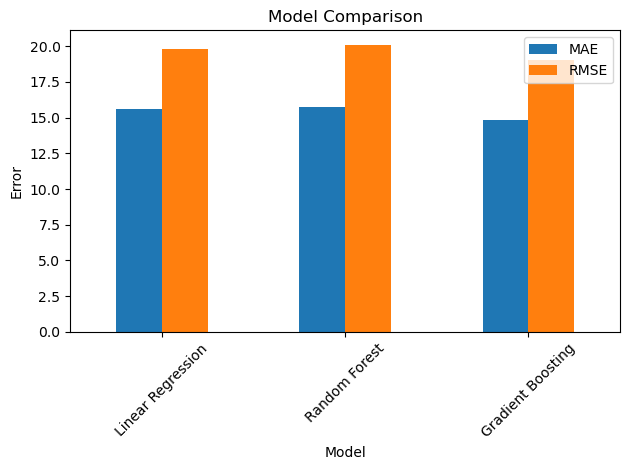

In [72]:
plt.figure(figsize=(10, 6))
results.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar')
plt.title('Model Comparison')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

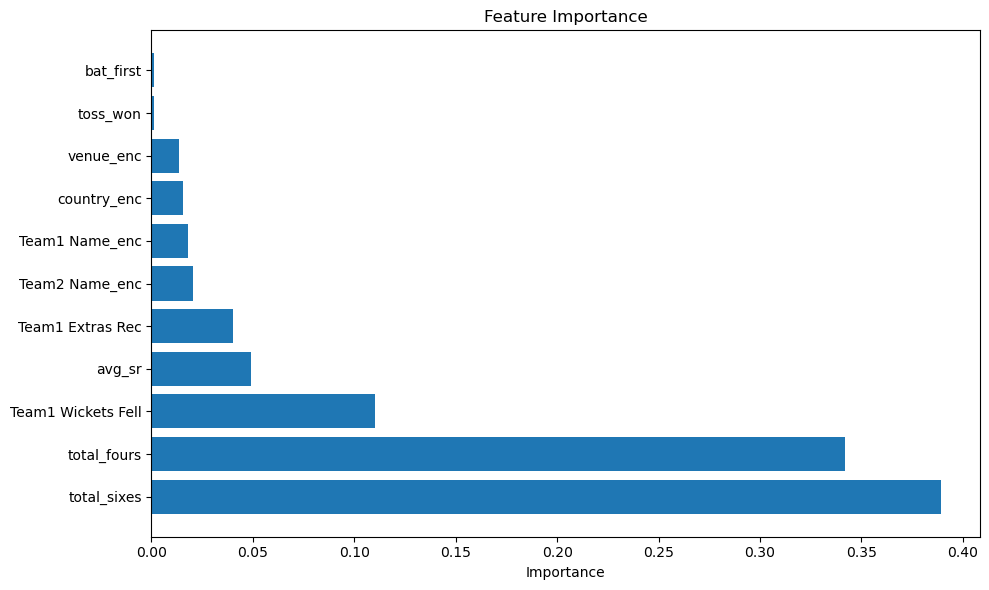

,feature,importance
9,total_sixes,0.388972
8,total_fours,0.341679
6,Team1 Wickets Fell,0.110434
10,avg_sr,0.048962
7,Team1 Extras Rec,0.040112
1,Team2 Name_enc,0.020551
0,Team1 Name_enc,0.018057
3,country_enc,0.015512
2,venue_enc,0.013437
4,toss_won,0.001259


In [73]:
best_model = gb

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

feature_importance

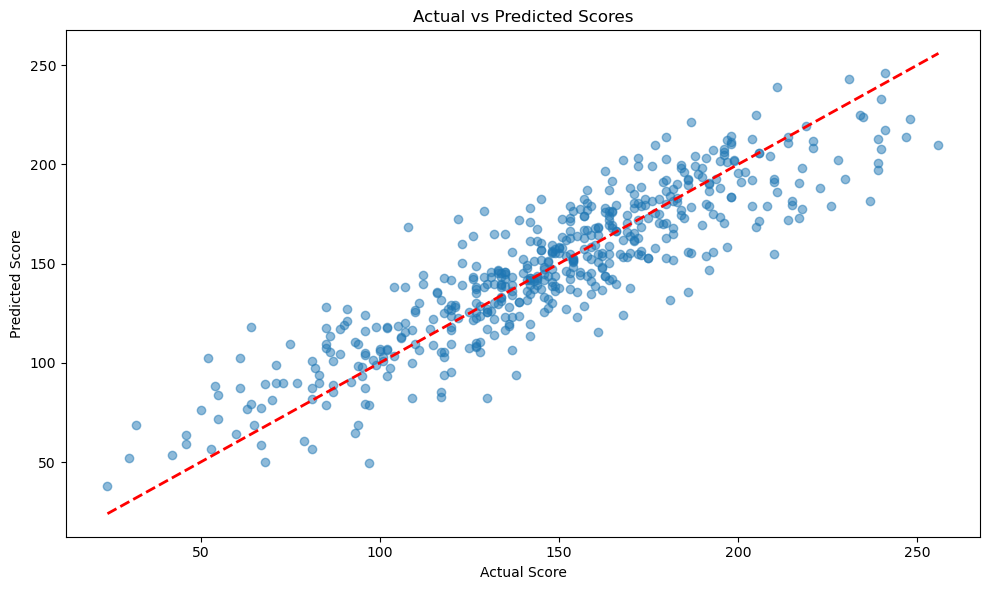

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores')
plt.tight_layout()
plt.show()

In [75]:
accuracy = r2_score(y_test, gb_pred) * 100
mae = mean_absolute_error(y_test, gb_pred)

print(f"Model Accuracy: {accuracy:.2f}%")
print(f"Average Error: {mae:.2f} runs")
print(f"\nOn average, predictions are off by {mae:.0f} runs")

Model Accuracy: 79.42%
Average Error: 14.84 runs

On average, predictions are off by 15 runs


In [82]:
import os

project_root = r'd:\Projects\AIagent\Cricket Score Prediction System'
model_path = os.path.join(project_root, 'models', 'cricket_score_model.pkl')

joblib.dump({
    'model': best_model,
    'encoders': encoders,
    'features': features
}, model_path)

print("Model saved successfully")
print(f"Saved to: {model_path}")

Model saved successfully
Saved to: d:\Projects\AIagent\Cricket Score Prediction System\models\cricket_score_model.pkl


In [84]:
def predict_score(team1, team2, venue, country, toss_won, bat_first, wickets=5, extras=10, fours=12, sixes=4, strike_rate=125):
    import os
    project_root = r'd:\Projects\AIagent\Cricket Score Prediction System'
    model_path = os.path.join(project_root, 'models', 'cricket_score_model.pkl')
    
    data = joblib.load(model_path)
    model = data['model']
    encoders = data['encoders']
    
    try:
        t1 = encoders['Team1 Name'].transform([team1])[0]
        t2 = encoders['Team2 Name'].transform([team2])[0]
        v = encoders['venue'].transform([venue])[0]
        c = encoders['country'].transform([country])[0]
    except:
        t1, t2, v, c = 0, 1, 0, 0
    
    X = np.array([[t1, t2, v, c, toss_won, bat_first, wickets, extras, fours, sixes, strike_rate]])
    score = model.predict(X)[0]
    return round(score)

In [85]:
score = predict_score('India', 'Australia', 'Mumbai', 'India', 1, 1)
print(f"Predicted Score: {score}")

Predicted Score: 111


In [86]:
score = predict_score('England', 'Pakistan', 'Dubai', 'United Arab Emirates', 0, 1, wickets=7, fours=15, sixes=6)
print(f"Predicted Score: {score}")

Predicted Score: 129


In [87]:
teams = list(encoders['Team1 Name'].classes_)
print(f"Total teams: {len(teams)}")
print(f"Teams: {teams[:15]}")

Total teams: 103
Teams: ['Afghanistan', 'Argentina', 'Australia', 'Austria', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belgium', 'Belize', 'Bermuda', 'Bhutan', 'Botswana', 'Brazil', 'Bulgaria', 'Cambodia']


In [88]:
venues = list(encoders['venue'].classes_)
print(f"Total venues: {len(venues)}")
print(f"Venues: {venues[:15]}")

Total venues: 166
Venues: ['Aberdeen', 'Abu Dhabi', 'Accra', 'Adelaide', 'Ahmedabad', 'Al Amarat', 'Albergaria', 'Almeria', 'Amstelveen', 'Apia', 'Auckland', 'Bali', 'Bangi', 'Bangkok', 'Basseterre']
